In [162]:
import sqlite3
import pandas as pd
import numpy as np
import re
import string
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('../redditPosts.sqlite')
cur = conn.cursor()

## Get the list of existing subreddits in the database.

In [9]:
cur.execute('''SELECT subreddit FROM Posts GROUP BY subreddit ORDER BY (COUNT(id))''')
subreddits = list(map(lambda x: x[0], cur.fetchall()))

subreddits

['Superstonks',
 'finance',
 'options',
 'pennystocks',
 'GME',
 'CryptoCurrency',
 'dogecoin',
 'wallstreetbets']

In [11]:
for subreddit in subreddits:
    cur.execute('''SELECT AVG(score), COUNT(score), flag FROM
                    (SELECT B.score, (CASE
                                    WHEN B.body == '[deleted]' OR B.body == '[removed]' THEN 0
                                    ELSE 1
                                    END) AS flag
                    FROM PostBodyAndScore B
                    JOIN (SELECT id FROM Posts WHERE subreddit ==?) P
                    On P.id = B.id) comb
                    GROUP BY flag''', (subreddit,))

    print(subreddit,cur.fetchall())

Superstonks [(1.4615384615384615, 26, 0), (12.1, 120, 1)]
finance [(16.512359550561797, 445, 0), (49.87940705128205, 2496, 1)]
options [(5.675890340763515, 7806, 0), (27.118068996925878, 8783, 1)]
pennystocks [(5.620451248495324, 32399, 0), (72.21061123177164, 16115, 1)]
GME [(45.454079474483066, 40189, 0), (137.4685982088646, 105408, 1)]
CryptoCurrency [(3.595744680851064, 282, 0), (67.27064220183486, 218, 1)]
dogecoin [(3.3076923076923075, 26, 0), (49.43283582089552, 67, 1)]
wallstreetbets [(20.44894198340757, 140546, 0), (196.9377785848714, 60574, 1)]


## Retrieve data from the database based on the subreddit.

In [20]:
subreddit = 'GME'
cmd = '''SELECT P.title, P.author, P.ext_link, P.created, B.body, B.score 
            FROM (SELECT * FROM Posts WHERE subreddit = '{}') P 
            JOIN PostBodyAndScore B
            On P.id = B.id
            WHERE B.body != "[removed]" AND B.body != "[deleted]"'''.format(subreddit)

df = pd.read_sql(cmd, conn)

In [21]:
df.head()

,title,author,ext_link,created,body,score
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18


In [29]:
df[df['score']> 1000].shape

df.shape

(3079, 6)

In [31]:
from sklearn.model_selection import train_test_split

In [181]:
df_model = df.copy()

df_model['Popular'] = 1*(df_model['score'] > 1000)

df_model.head()

,title,author,ext_link,created,body,score,Popular
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6,0
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2,0
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14,0
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11,0
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18,0


In [182]:
def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def hourOfDay(utc):
    return dt.datetime.utcfromtimestamp(utc).hour

def dayOfWeek(utc):
    return dt.datetime.utcfromtimestamp(utc).weekday()

def textLength(text):
    return len(text.split())

def postType(link):
    if not link:
        return 'others'
    if 'png' in link or 'jpg' in link:
        return 'figures'
    elif '/r/' in link:
        return 'others'
    else:
        return 'outside_link'

def featureProcessing(df_model):
    df_model['title_emoji'] = df_model['title'].apply(emoji_count)
    df_model['body_emoji'] = df_model['body'].apply(emoji_count)
    df_model['hour'] = df_model['created'].apply(hourOfDay)
    df_model['day'] = df_model['created'].apply(dayOfWeek)
    df_model['title_length'] = df_model['title'].apply(textLength)
    df_model['body_length'] = df_model['body'].apply(textLength)
    df_model['post_type'] = df_model['ext_link'].apply(postType)

In [183]:
featureProcessing(df_model)

In [184]:
df_model.head()

,title,author,ext_link,created,body,score,Popular,title_emoji,body_emoji,hour,day,title_length,body_length,post_type
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6,0,6,3,19,0,8,11,others
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2,0,1,11,10,1,10,17,others
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14,0,0,1,13,2,4,86,others
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11,0,3,5,21,6,14,43,others
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18,0,0,0,12,0,5,0,outside_link


In [185]:
df_model[['figures', 'outside_link']] = pd.get_dummies(df_model['post_type'])[['figures', 'outside_link']]

In [186]:
df_model.head()

,title,author,ext_link,created,body,score,Popular,title_emoji,body_emoji,hour,day,title_length,body_length,post_type,figures,outside_link
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6,0,6,3,19,0,8,11,others,0,0
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2,0,1,11,10,1,10,17,others,0,0
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14,0,0,1,13,2,4,86,others,0,0
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11,0,3,5,21,6,14,43,others,0,0
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18,0,0,0,12,0,5,0,outside_link,0,1


In [187]:
df_model['hour'] = df_model['hour'].astype('category')
df_model['day'] = df_model['day'].astype('category')


In [188]:
df_model.dtypes

title             object
author            object
ext_link          object
created            int64
body              object
score              int64
Popular            int32
title_emoji        int64
body_emoji         int64
hour            category
day             category
title_length       int64
body_length        int64
post_type         object
figures            uint8
outside_link       uint8
dtype: object

## Training the Model

Since the dataset is quite imbalanced (~3% popular posts), I decided to use oversampling to make a balanced dataset. One thing I realized is that I should not oversample before splitting the dataset into training/testing sets, as the testing datapoints will have leaked into the training set. 

By extension, the cross validation also shouldn't be performed if we oversample. I did not think of that when writing this block, so you can see that the cross validation gives increasingly good results as the complexity increases. 

In [129]:
columns = ['title_emoji', 'body_emoji', 'hour', 'day', 'title_length', 'body_length', 'figures', 'outside_link' ,'Popular']
df_features = df_model[columns]

In [146]:
X = df_features.drop(columns = ['Popular'])
y = df_model['Popular']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

In [158]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_nonPopular = df_train[df_train['Popular'] == 0]
df_Popular = df_train[df_train['Popular'] == 1]

df_balanced = pd.concat([df_nonPopular, df_Popular.sample(n = df_nonPopular.shape[0], replace = True)], axis = 0)

X_train = df_balanced[columns].drop(columns = ['Popular']).to_numpy()
y_train = df_balanced['Popular'].to_numpy()


In [144]:
from sklearn.tree import DecisionTreeClassifier

In [159]:
X_train.shape

(163726, 8)

In [152]:
tree_clf = DecisionTreeClassifier(max_depth = 10)

tree_clf.fit(X_train, y_train)
tree_clf.score(X_test, y_test)

0.6874110615691111

In [151]:
from sklearn.metrics import confusion_matrix

In [153]:
yPred = tree_clf.predict(X_test)

confusion_matrix(y_test, yPred)

array([[14126,  6340],
       [  250,   366]], dtype=int64)

In [154]:
yPred = tree_clf.predict(X_train)

confusion_matrix(y_train,yPred)

array([[56971, 24892],
       [16785, 65078]], dtype=int64)

In [157]:
from sklearn.model_selection import KFold

In [166]:
splits = 5
depths = range(15,25)

CV = np.zeros((5,len(depths)))
kf = KFold(splits)

for i,(train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_train, X_train_val = X_train[train_index,:], X_train[val_index,:]
    y_train_train, y_train_val = y_train[train_index], y_train[val_index]
    
    for j,depth in enumerate(depths):
        tree_clf = DecisionTreeClassifier(max_depth = depth)
        tree_clf.fit(X_train_train, y_train_train)
        CV[i,j] = tree_clf.score(X_train_val, y_train_val)



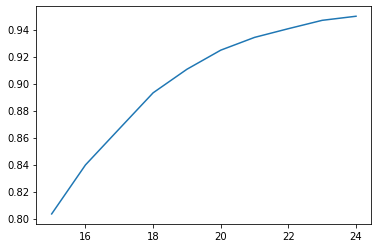

In [168]:
plt.plot(depths, np.mean(CV, axis = 0))

In [176]:
tree_clf = DecisionTreeClassifier(max_depth = 4)
tree_clf.fit(X_train, y_train)
yPred = tree_clf.predict(X_test)

confusion_matrix(y_test, yPred)

array([[14215,  6251],
       [  214,   402]], dtype=int64)

In [172]:
from sklearn.ensemble import RandomForestClassifier

In [175]:
rf = RandomForestClassifier(max_depth = 4)

rf.fit(X_train, y_train)
yPred = rf.predict(X_test)

confusion_matrix(y_test, yPred)

array([[13400,  7066],
       [  190,   426]], dtype=int64)

In [179]:
names = []
scores = []
for name, score in zip(df_balanced.columns,rf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
4,title_length,0.3364
5,body_length,0.2731
6,figures,0.1484
1,body_emoji,0.1448
3,day,0.0317
0,title_emoji,0.0262
7,outside_link,0.0257
2,hour,0.0138
